In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import tectosaur
import tectosaur.mesh.mesh_gen
from scipy.sparse.linalg import spsolve
from tectosaur.mesh.combined_mesh import CombinedMesh
from tectosaur.ops.mass_op import MassOp
from tectosaur.ops.sparse_integral_op import SparseIntegralOp, FMMFarfieldBuilder
from tectosaur.constraint_builders import free_edge_constraints
from tectosaur.constraints import build_constraint_matrix

In [19]:
sm = 3e10 # Pa
pr = 0.25 
density = 2700 # kg/m^3
cfg = dict(
    preconditioner = 'none',
    quad_mass_order = 4,
    quad_vertadj_order = 8,
    quad_far_order = 3,
    quad_near_order = 5,
    quad_near_threshold = 2.5,
    float_type = np.float32,
    use_fmm = True,
    fmm_order = 150,
    fmm_mac = 3.0,
    pts_per_cell = 450,
    log_level = logging.INFO
)

def make_integral_op(m, k_name, k_params, cfg, name1, name2):
    if cfg['use_fmm']:
        farfield = FMMFarfieldBuilder(
            cfg['fmm_order'], cfg['fmm_mac'], cfg['pts_per_cell']
        )
    else:
        farfield = None
    return SparseIntegralOp(
        cfg['quad_vertadj_order'], cfg['quad_far_order'],
        cfg['quad_near_order'], cfg['quad_near_threshold'],
        k_name, k_params, m.pts, m.tris, cfg['float_type'],
        farfield_op_type = farfield,
        obs_subset = m.get_tri_idxs(name1),
        src_subset = m.get_tri_idxs(name2)
    )

def make_mass_op(m, cfg):
    return MassOp(cfg['quad_mass_order'], m.pts, m.tris)

In [3]:
n_fault = 30
L = 10 * 1000
W = 10 * 1000
fault_m = tectosaur.mesh.mesh_gen.make_rect(n_fault, n_fault, [
    [-L, 0, W], [-L, 0, -W],
    [L, 0, -W], [L, 0, W]
])
m = CombinedMesh.from_named_pieces([('fault', fault_m)])

In [4]:
cs = free_edge_constraints(m.get_tris('fault'))
cm, c_rhs = build_constraint_matrix(cs, m.n_dofs('fault'))

In [5]:
constrained_slip = np.ones(cm.shape[1])
slip1m = cm.dot(constrained_slip).reshape(-1,3)
slip1m[:,1] = 0.0
slip1m[:,2] = 0.0

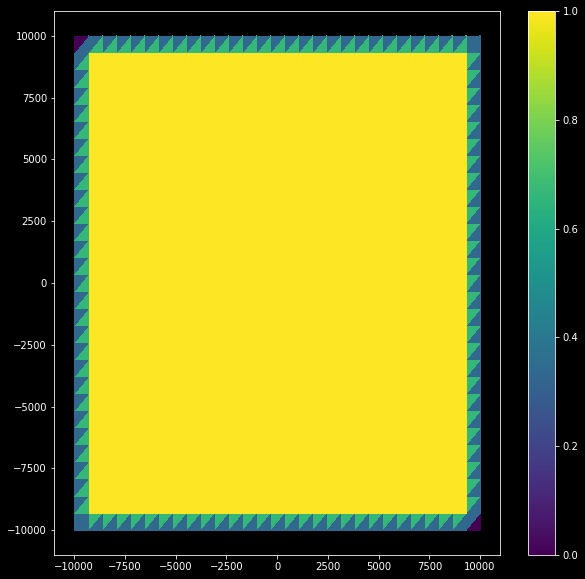

In [6]:
def plot_field(field, d):
    plt.style.use('dark_background')
    pt_field = np.empty(m.pts.shape)
    pt_field[m.tris] = field.reshape(-1,3,3)
    plt.figure(figsize = (10,10))
    plt.tripcolor(m.pts[:,0], m.pts[:,2], m.tris, pt_field[:,d])
    plt.colorbar()
    plt.show()
plot_field(slip1m, 0)

In [7]:
hypersingular_op = make_integral_op(m, 'elasticH3', [sm, pr], cfg, 'fault', 'fault')
traction_mass_op = make_mass_op(m, cfg)

[1736:DEBUG:tectosaur.util.gpu]
    start compiling nearfield/nearfield.cl
[2773:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0
[3297:DEBUG:tectosaur.util.gpu]
    compile took 1.5600736141204834
[3312:DEBUG:tectosaur.nearfield.nearfield_op]
        setup pairs integrator took 1.6437914371490479
[3346:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- load table took 0.005948543548583984
[3350:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- get pts took 0.002450227737426758
[3365:DEBUG:tectosaur.util.gpu]
    start compiling nearfield/interpolate_kernel.cl
[3618:DEBUG:tectosaur.util.gpu]
    compile took 0.25276756286621094
[3642:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- interpolate took 0.2908809185028076
[3646:DEBUG:tectosaur.nearfield.table_lookup]
    coincident -- from standard took 0.00302886962890625
[3647:DEBUG:tectosaur.nearfield.nearfield_op]
        Coincident took 0.3341538906097412
[3652:DEBUG:tectosaur.nearfield.nearfield_op]
   

In [8]:
plate_rate = 0.050 # 50 mm/yr
dt = 0.01 # 0.01 yr/step

In [9]:
cs = np.sqrt(sm / density)
eta = sm / (2 * cs)

In [ ]:
a = 0.015
V0 = 1e-6
b = 0.02
Dc = 0.2
f0 = 0.6
kcrit = sigma_n * b / Dc
print('k/kcrit =', k / kcrit)

# Rate-state friction law w/ Rice et al 2001 regularization so that 
# it is valid at V = 0
def F(V, sigma_n, state):
    return a * sigma_n * np.arcsinh(V / (2 * V0) * np.exp(state / a))

# State evolution law -- aging law.
def G(V, state):
    return (b * V0 / Dc) * (np.exp((f0 - state) / b) - (V / V0))

In [16]:
t = 0
slip = np.zeros(slip1m.size)
slip_vel = slip.copy()
state = np.zeros(slip1m.shape[0])

slip += dt * plate_rate * slip1m.reshape(-1)
t += dt
rhs = hypersingular_op.dot(slip)
traction_static = spsolve(traction_mass_op.mat, -rhs)
traction_qd = traction_static - eta * slip_vel

# tau from friction law
# slip += v * dt

# then use the time-stepper to update

[81384:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[81412:DEBUG:tectosaur.ops.sparse_integral_op]
    nearfield_dot took 0.02838611602783203
[81414:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[81416:DEBUG:tectosaur.ops.sparse_integral_op]
    to tree space took 0.0004298686981201172
[81489:DEBUG:tectosaur.ops.sparse_integral_op]
    fmm eval took 0.0716254711151123
[81491:DEBUG:tectosaur.ops.sparse_integral_op]
    to output space took 0.0005996227264404297
[81493:DEBUG:tectosaur.ops.sparse_integral_op]
    farfield_dot took 0.07945561408996582


In [18]:
slip.shape

(15138,)